# Loading Model and Testing

In [1]:
! ls

Base_transformer.ipynb	Base_transformer.py  __pycache__  play_loader.py


In [2]:
import sys
import os
import tensorflow as tf
import numpy as np
import pandas as pd

from importlib import reload

from Base_transformer import TransformerPredictor 
from play_loader import load_play

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))
import custom_visualizer; reload(custom_visualizer)
from custom_visualizer import (
    extract_subset_from_dataloader,
    covert_sequences_to_df,
    extract_full_sequence,
    plot_trajectories,)     # <-- the file we made

2025-04-30 22:45:46.213190: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-30 22:45:46.413811: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746049546.494237    1899 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746049546.513119    1899 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746049546.675950    1899 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
# (optional) remind yourself of GPU & precision settings
print("Visible GPUs:", tf.config.list_physical_devices("GPU"))

Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
#WEIGHT_PATTERN = "weights/epoch_{:03d}-val{:.4f}.weights.h5"

WEIGHT_FILE = "../../weights/epoch_015-val0.0000.weights.h5"   # adjust as needed

model = TransformerPredictor(dtype_policy="mixed_float16")  # or omit arg for fp32
#model = TransformerPredictor()
model.load_weights(WEIGHT_FILE)

model.summary()  # sanity-check layer names/shapes match the notebook

I0000 00:00:1746049552.796179    1899 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9511 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "NFL_Frame_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence            │ (None, 100, 46)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_11 (Cast)      │ (None, 100, 46)   │          0 │ sequence[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ proj_xy (Dense)     │ (None, 100, 128)  │      6,016 │ cast_11[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_12 (Cast)      │ (None, 100, 46)   │          0 │ sequence[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pos_enc             │ (None, 100, 128)  │     12,800 │ proj_xy[0][0]     │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pad_mask            │ (None, 1, 1, 100) │          0 │ cast_12[0][0]     │
│ (PaddingMask)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_4        │ (None, 100, 128)  │    198,272 │ pos_enc[0][0],    │
│ (Functional)        │                   │            │ pad_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_5        │ (None, 100, 128)  │    198,272 │ functional_4[0][… │
│ (Functional)        │                   │            │ pad_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_6        │ (None, 100, 128)  │    198,272 │ functional_5[0][… │
│ (Functional)        │                   │            │ pad_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_7        │ (None, 100, 128)  │    198,272 │ functional_6[0][… │
│ (Functional)        │                   │            │ pad_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_last_hidden  │ (None, 128)       │          0 │ functional_7[0][… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_21 (Cast)      │ (None, 128)       │          0 │ lambda_last_hidd… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pred_xy (Dense)     │ (None, 46)        │      5,934 │ cast_21[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 817,838 (3.12 MB)

 Trainable params: 817,838 (3.12 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
batch_size   = 8
timesteps_in = 80                    # < MAX_LEN just for demo
dummy_seq_batch = tf.random.uniform([batch_size, timesteps_in, 46])
dummy_seq = tf.random.uniform([timesteps_in, 46])

In [6]:
y_next = model.predict_next(dummy_seq)      # (8, 46)
print("Next-frame prediction shape:", y_next.shape)

2025-04-30 22:45:54.871377: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


Next-frame prediction shape: (46,)


In [7]:
n_future = 10
y_future = model.predict_autoregressive(dummy_seq, n_steps=n_future)  # (8, 10, 46)
print("Autoregressive rollout shape:", y_future.shape)

Autoregressive rollout shape: (10, 46)


# Vissualizing

In [8]:
DATASET_PATH = "../../processed_data/transformer_dataset"

def filter_split(split_num):
    def _filter(meta, x, y):
        return tf.equal(meta[2], split_num)
    return _filter

def drop_meta(meta, x, y):
    return x, y

raw_ds = tf.data.Dataset.load(DATASET_PATH)

test_ds  = (raw_ds
            .filter(filter_split(2))
            .shuffle(4096)
            .batch(1)
            .prefetch(tf.data.AUTOTUNE))



In [9]:
play = next(iter(test_ds))            # a single batch (meta, x, y)

meta, x_ctx, y_next = play            # x_ctx: (1,100,46)

2025-04-30 22:46:06.935226: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1347 of 4096
2025-04-30 22:46:21.797868: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


In [10]:
n_future = 40
y_future = model.predict_autoregressive(x_ctx, n_steps=n_future)  # (1,100,46)

print("context shape:", x_ctx.shape)
print("future   shape:", y_future.shape)

context shape: (1, 100, 46)
future   shape: (1, 40, 46)


In [11]:
full_pred = tf.concat([x_ctx, y_future], axis=1)      # (1,200,46)

# If you **do** have the full ground-truth sequence for this play
# (not just y_next), put it here; otherwise set ground_truth_seq=None
ground_truth_seq = None            # ← replace when available

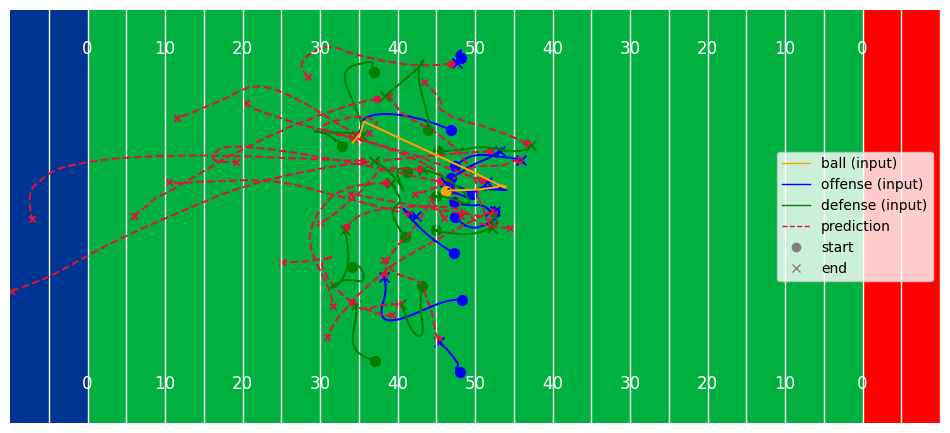

In [12]:
_ = plot_trajectories(
        sequence=x_ctx[0],                 # solid lines:   100-frame context
        offense='all', defense='all', include_ball=True,
        ground_truth_seq=(ground_truth_seq[:, 100:] if ground_truth_seq is not None else None),
        pred_seq=full_pred[:, 100:],       # dashed lines: model rollout
        gt_linestyle='-.', pred_linestyle='--',
        gt_color='limegreen', pred_color='crimson')

In [13]:
from play_loader import load_play

In [14]:
import pandas as pd

In [15]:
game_indexer = pd.read_parquet("../../processed_data/train_test_val.parquet")

game_indexer.loc[1]

gameId    2022103006
playId          2387
split           test
Name: 1, dtype: object

In [16]:
# Filter to test rows and pick one at random
row = (
    game_indexer
    .loc[game_indexer['split'] == "train", ['gameId', 'playId']]
    .sample(n=1, random_state=42)  # you can omit random_state for true randomness
)

# Extract into Python variables
gameId = row['gameId'].iloc[0]
playId = row['playId'].iloc[0]

print(f"Selected gameId = {gameId}, playId = {playId}")
row

Selected gameId = 2022102305, playId = 648


,gameId,playId
10637,2022102305,648


In [17]:
df = pd.read_parquet("../../processed_data/model_input_2.parquet")
df

,gameId,playId,frameId,x_1,x_2,x_3,x_4,x_5,x_6,x_7,...,quarter_5,down_2,down_3,down_4,yardsToGo,possessionTeam,gameClock,preSnapHomeScore,preSnapVisitorScore,yardsToScore
0,2022090800,56,1,0.745667,0.740000,0.759000,0.747667,0.754167,0.757333,0.763667,...,0,0,0,0,10,BUF,1.000000,0.00,0.00,75
1,2022090800,56,2,0.744917,0.738250,0.758833,0.746750,0.753750,0.757583,0.763833,...,0,0,0,0,10,BUF,1.000000,0.00,0.00,75
2,2022090800,56,3,0.744000,0.736500,0.758667,0.745833,0.753333,0.757833,0.763917,...,0,0,0,0,10,BUF,1.000000,0.00,0.00,75
3,2022090800,56,4,0.742917,0.734833,0.758417,0.744917,0.752917,0.758250,0.764083,...,0,0,0,0,10,BUF,1.000000,0.00,0.00,75
4,2022090800,56,5,0.741667,0.733250,0.758083,0.743833,0.752500,0.758500,0.764167,...,0,0,0,0,10,BUF,1.000000,0.00,0.00,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600388,2022091901,4000,107,0.243333,0.093583,0.218500,0.206917,0.126833,0.093833,0.109000,...,0,0,1,0,11,MIN,0.025556,0.48,0.14,11
600389,2022091901,4000,108,0.245333,0.089833,0.217250,0.206750,0.126917,0.089167,0.105917,...,0,0,1,0,11,MIN,0.025556,0.48,0.14,11
600390,2022091901,4000,109,0.247083,0.086167,0.216000,0.206417,0.127167,0.084500,0.103167,...,0,0,1,0,11,MIN,0.025556,0.48,0.14,11
600391,2022091901,4000,110,0.248667,0.082667,0.214583,0.205917,0.127583,0.080000,0.100750,...,0,0,1,0,11,MIN,0.025556,0.48,0.14,11


In [18]:
df = pd.read_parquet(
        "../../processed_data/model_input_2.parquet",
        engine="pyarrow",
        filters=[("gameId", "==", 2022090800), ("playId", "==", 56)],
    )

df[["event_ball_snap","event_snap_direct", "event_Nothing"]]

KeyError: "['event_Nothing'] not in index"

In [ ]:
context_seq, gt_future = load_play(
    parquet_path="../../processed_data/model_input_2.parquet",
    game_id=2022091901,
    play_id=4000,
    ctx_len=100,
    n_future=40,
    
)

/mnt/c/Users/sebas/Desktop/LSE_2.0/MSc Statistics/ST456 Deep Learning/2025-projects-shallowlearning/code/Models


KeyError: "['event_autoevent_ballsnap'] not in index"